In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math



Bad key "lines.dashed_pattern" on line 18 in
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "lines.dashdot_pattern" on line 19 in
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "lines.dotted_pattern" on line 20 in
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
o

In [3]:
def make_signal(w,theta,n):
    """
    Assumes normalized amplitude
    """
    t = np.arange(n)
    signal = np.exp(1j*(w*t + theta))
    return signal

def make_noise(sigma2,n):
    noise_scaling = np.sqrt(sigma2/2)
    # noise is complex valued
    noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
    return noise

def make_noisy_signal(w,theta,SNRdb,n):
    sigma2 = get_sigma2_from_snrdb(SNRdb)
    signal = make_signal(w,theta,n)
    noise  = make_noise(sigma2,n)
    return signal + noise

# N = divisor of w0
# m = num samples
def make_batch_noisy(batch_size, SNRdb, N, m, binary=False):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        w = (2 * np.pi * freq / N) % (2 * np.pi)
        sig = make_noisy_signal(w, 0, SNRdb, m)
        signals.append(sig)
        freqs.append(freq)
    if binary:
        return signals, make_binary(freqs, N), one_hot(N, batch_size, freqs)
    return signals, one_hot(N, batch_size, freqs)

# N = divisor of w0
# m = num samples
# starts = shift for each subsequent sample
def make_batch_noisy_lohi(batch_size, SNRdb, N, m, starts=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]):
    freqs = []
    freqs.append(np.random.randint(0, N))
    test_signals, test_freqs = make_noisy_lohi(SNRdB, N, m, freqs[-1], starts)
    for i in range(1, batch_size):
        freqs.append(np.random.randint(0, N))
        a, b = make_noisy_lohi(SNRdB, N, m, freqs[-1], starts)
        test_signals.extend(a)
        test_freqs.extend(b)
    return test_signals, test_freqs, freqs

def make_noisy_lohi(SNRdb, N, m, freq, starts):
    signals, vals = [], []
    steps = int(np.log2(N))
    w = (2 * np.pi * freq / N) % (2 * np.pi)
    sig = make_noisy_signal(w, 0, SNRdb, N)
    #start = 0
    for i in range(int(np.log2(N))):
        #start = start + np.random.randint(N // 4) if i > 0 else 0
        signals.append([sig[(starts[i] + a * (2**i)) % N] for a in range(m)])
        if (freq * (2**i)) % (N) < N / 2:
            vals.append([0])
        else:
            vals.append([1])
    return signals, vals
        

def make_batch_singleton(batch_size, SNRdb, N, m, default=-1): # 0 = zero, 1 = single, 2 = multi
    signals, freqs = [], []
    sigma2 = get_sigma2_from_snrdb(SNRdB)
    for i in range(batch_size):
        val = np.random.poisson(0.79)
        if default >= 0:
            val = default
        if val == 0:
            signals.append(make_noise(0, m))
            freqs.append([1, 0, 0])
        if val == 1:
            signals.append(make_noisy_signal(2 * np.pi * np.random.randint(0, N) / N, 0, SNRdB, m))
            freqs.append([0, 1, 0])
        if val >= 2:
            signal = make_signal(2 * np.pi * np.random.randint(0, N) / N, 0, m)
            for i in range(val - 1):
                signal += make_signal(2 * np.pi * np.random.randint(0, N) / N, 0, m)
            signals.append(signal + make_noise(sigma2, m))
            freqs.append([0, 0, 1])
    return signals, freqs

def get_sigma2_from_snrdb(SNR_db):
    return 10**(-SNR_db/10)

def kay_weights(N):
    scaling = (3.0/2)*N/(N**2 - 1)
    
    w = [1 - ((i - (N/2 - 1))/(N/2))**2 for i in range(N-1)]
    
    return scaling*np.array(w)

def kays_method(my_signal):
    N = len(my_signal)
    w = kay_weights(N)
    
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
    need_to_shift = np.any(angle_diff < -np.pi/2)
    if need_to_shift:    
        neg_idx = angle_diff < 0
        angle_diff[neg_idx] += np.pi*2
    
    return w.dot(angle_diff)

def kays_singleton_accuracy(test_signals, test_freqs, N):
    diffs = [s - make_signal(kays_method(s), 0, N) for s in test_signals]
    thresh, single_acc, other_acc, best_thresh = 0.0, 0, 0, 0
    best = 0
    for i in range(150):
        vals = [(sum(np.absolute(s)) / N) < thresh for s in diffs]
        corr = [1 for i in range(len(test_freqs)) if (test_freqs[i] == [0, 1, 0] and vals[i] == 1) or ((test_freqs[i] != [0, 1, 0] and vals[i] == 0))]
        corr = sum(corr)
        #single = sum([vals[d] for d in range(len(vals)) if test_freqs[d] == [0, 1, 0]]) / len([vals[d] for d in range(len(vals)) if test_freqs[d] == [0, 1, 0]])
        #other = sum([not vals[d] for d in range(len(vals)) if test_freqs[d] != [0, 1, 0]]) / len([vals[d] for d in range(len(vals)) if test_freqs[d] != [0, 1, 0]])        
        #if single*2 + other > single_acc*2 + other_acc and single > 0.2 and other > 0.2:
        #    single_acc = single
        #    other_acc = other
        #    best_thresh = thresh
        if corr > best:
            best = corr
            best_thresh = thresh
        thresh += 0.05
    print('thresh: ', best_thresh)
    return best / len(test_signals)

def test_kays(signals, freqs, N):
    count = 0
    for sig, freq in zip(signals, freqs):
        res = kays_method(sig)
        res = round(res * N / (2 * np.pi))
        if np.argmax(freq) == res:
            count += 1
    return count / len(signals)

def test_mle(signals, freqs, N, m):
    count = 0
    for sig, freq in zip(signals, freqs):
        cleans = [make_signal(np.pi * 2 * w / N, 0, m) for w in range(N)]
        dots = [np.absolute(np.vdot(sig, clean)) for clean in cleans]
        if np.argmax(dots) == np.argmax(freq):
            count += 1
    return count / len(signals)
    
def make_binary(freqs, N):
    w = math.ceil(np.log2(N))
    return [[int(a) for a in list(np.binary_repr(f, width=w))] for f in freqs] 

def binary_to_int(binary_string):
    return tf.reduce_sum(
    tf.cast(tf.reverse(tensor=binary_string, axis=[0]), dtype=tf.int64)
    * 2 ** tf.range(tf.cast(tf.size(binary_string), dtype=tf.int64)))
    '''y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y'''

def hamming(pred, act):
    return np.count_nonzero(pred != act)

def one_hot(N, batch_size, freqs):
    freqs_one_hot = np.zeros((batch_size, N))
    freqs_one_hot[np.arange(batch_size), freqs] = 1
    return freqs_one_hot

def test_noisy_mle(N, m, signals, freqs):
    count = 0  
    '''imag_signals = []
    for index in range(len(signals)):
        sig = signals[index]
        imag_sig = [(sig[i] + 1j*sig[i+1]) for i in np.arange(len(sig), step=2)]
        imag_signals.append(imag_sig)'''
    cleans = [make_signal(2*np.pi*i/N, 0, m) for i in range(N)]
                     
    for index in range(len(signals)):
        dots = [np.absolute(np.vdot(signals[index], cleans[i])) for i in range(N)]
        if np.argmax(freqs[index]) == np.argmax(dots):
            #print(np.argmax(dots))
            count += 1
    return count / len(freqs)

def bit_to_freq(bits, N):
    possible = [i for i in range(N)]
    for b in bits:
        if not b[0]:
            possible = possible[:len(possible)//2]
        else:
            possible = possible[len(possible)//2:]
    return possible[0]

In [7]:
# div and conquer freq detect

N = 16384 
layer = 2    #6
m = 30

log = int(np.log2(N))

# Parameters
learning_rate = 0.005
num_iter = 10000 #80000
batch_size = log * 20



# Network Parameters
num_classes = 1

#snrs = [10, 8, 6, 4, 2, 0, -2]
snrs = [4, 2, 0, -1]

bin_accs = []
freq_accs = []
all_preds = []
all_actuals = []

#starts = [0]
#for i in range(1, log): # filling all the starting points
#    starts.append(starts[i-1] + np.random.randint(N // 4))

starts = [0] * 15

for SNRdB in snrs:
    print(SNRdB)

    t_bins = []
    t_freqs = []
    t_preds = []
    t_actuals = []
    
    training_size = 400 #5999
    dict = {}
    for i in range(training_size):
        if i % 500 == 0:
            print(i)
        batch_x, batch_y, batch_freqs = make_batch_noisy_lohi(batch_size // log, SNRdB - (i % 3), N, m, starts)
        batch_x_pair = np.zeros((batch_size, m, 2))
        batch_x_pair[:, :, 0] = np.real(batch_x)
        batch_x_pair[:, :, 1] = np.imag(batch_x)
        dict[i] = (batch_x_pair, batch_y)
    
    for trial in range(4):
        print(trial)
        # tf Graph input
        X = tf.placeholder("float", [None, m, 2])
        Y = tf.placeholder("float", [None, num_classes])

        # Store layers weight & bias
        weights = {i: tf.Variable(tf.random_normal([3, 2, 2])) for i in range(1, layer+1)} # increase out channels, less layers
        weights[0] = tf.Variable(tf.random_normal([5, 2, 2]))
        weights['out'] = tf.Variable(tf.random_normal([(m-4-(0*layer))*2, num_classes]))
        biases = {i: tf.Variable(tf.random_normal([2])) for i in range(layer+1)}
        biases['out'] = tf.Variable(tf.random_normal([num_classes]))


        def neural_net(x):
            layer_1 = tf.add(tf.nn.conv1d(x, weights[0], 1, 'VALID'), biases[0])
            hidden_1 = tf.nn.relu(layer_1)
            for i in range(1, layer+1):
                layer_1 = tf.add(tf.nn.conv1d(hidden_1, weights[i], 1, 'SAME'), biases[i]) # no padding
                hidden_1 = tf.nn.relu(layer_1) # try: elu, leaky
                ### instance normalize
            hidden_3 = tf.reshape(hidden_1, [batch_size, -1])
            out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
            return out_layer


        test_dict = {}
        for i in range(10):
            test_signals, test_freqs, freqs = make_batch_noisy_lohi(batch_size // log, SNRdB, N, m, starts)
            test_signals_pair = np.zeros((batch_size, m, 2))
            test_signals_pair[:, :, 0] = np.real(test_signals)
            test_signals_pair[:, :, 1] = np.imag(test_signals)
            test_dict[i] = (test_signals_pair, test_freqs, freqs)



        # Construct model
        logits = neural_net(X)
        prediction = tf.nn.sigmoid(logits)
        losses, accuracies = [], []

        # Define loss and optimizer
        loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=Y))  

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op)

        # Evaluate model
        pred_class = tf.greater(prediction, 0.5)
        correct_pred = tf.equal(pred_class, tf.equal(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()

        # Start training
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)
            print("Training Started")

            for step in range(1, num_iter + 1):
                batch_x_pair, batch_y = dict[step % training_size]

                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
                if step % 500 == 0:
                    # Calculate batch loss and accuracy
                    loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x_pair,
                                                                         Y: batch_y})

                    accuracies.append(acc)
                    losses.append(loss)
                    print("Iter " + str(step) + ", Minibatch Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))
            print("Training Finished")
            preds = [sess.run(prediction, feed_dict={X: test_dict[i][0], Y: test_dict[i][1]}) for i in range(len(test_dict))]  
            nn_acc = [sess.run(accuracy, feed_dict={X: test_dict[i][0], Y: test_dict[i][1]}) for i in range(len(test_dict))]   
            print(nn_acc)
        t_preds.append(preds)
        t_actuals.append([test_dict[i][1] for i in range(len(test_dict))])

        t_bins.append(np.median(nn_acc))
        preds = np.round(preds)
        corr = []
        for a in range(len(test_dict)):
            fs = []
            for k in range(len(preds[a]) // log):
                    fs.append(bit_to_freq(preds[a][k * log : (k+1) * log], N))
            corr.extend([fs[i] == test_dict[a][2][i] % N for i in range(len(fs))])
        t_freqs.append(np.sum(corr) / (len(fs) * len(test_dict)))
        print(t_freqs[-1])
    bin_accs.append(max(t_bins))
    freq_accs.append(max(t_freqs))
    all_preds.append(t_preds[np.argmax(t_freqs)])
    all_actuals.append(t_actuals[np.argmax(t_freqs)])
    print(bin_accs[-1])
    print(freq_accs[-1])
    
'''np.save('./data/testing/snrs', snrs)   
np.save('./data/testing/acc_binary', bin_accs)
np.save('./data/testing/acc_frequency', freq_accs)
np.save('./data/testing/preds_frequency', all_preds)
np.save('./data/testing/actuals_frequency', all_actuals)'''




4
0
0
Training Started
Iter 500, Minibatch Loss= 0.3787, Training Accuracy= 0.832
Iter 1000, Minibatch Loss= 0.1190, Training Accuracy= 0.968
Iter 1500, Minibatch Loss= 0.0443, Training Accuracy= 0.986
Iter 2000, Minibatch Loss= 0.1002, Training Accuracy= 0.975
Iter 2500, Minibatch Loss= 0.1106, Training Accuracy= 0.975
Iter 3000, Minibatch Loss= 0.0542, Training Accuracy= 0.979
Iter 3500, Minibatch Loss= 0.0195, Training Accuracy= 0.996
Iter 4000, Minibatch Loss= 0.0868, Training Accuracy= 0.971
Iter 4500, Minibatch Loss= 0.1051, Training Accuracy= 0.979
Iter 5000, Minibatch Loss= 0.0431, Training Accuracy= 0.982
Iter 5500, Minibatch Loss= 0.0237, Training Accuracy= 0.993
Iter 6000, Minibatch Loss= 0.0894, Training Accuracy= 0.975
Iter 6500, Minibatch Loss= 0.1057, Training Accuracy= 0.975
Iter 7000, Minibatch Loss= 0.0365, Training Accuracy= 0.986
Iter 7500, Minibatch Loss= 0.0228, Training Accuracy= 0.993
Iter 8000, Minibatch Loss= 0.0830, Training Accuracy= 0.979
Iter 8500, Minibat

Iter 1000, Minibatch Loss= 0.6627, Training Accuracy= 0.575
Iter 1500, Minibatch Loss= 0.5468, Training Accuracy= 0.732
Iter 2000, Minibatch Loss= 0.2772, Training Accuracy= 0.889
Iter 2500, Minibatch Loss= 0.4141, Training Accuracy= 0.846
Iter 3000, Minibatch Loss= 0.2463, Training Accuracy= 0.921
Iter 3500, Minibatch Loss= 0.1529, Training Accuracy= 0.954
Iter 4000, Minibatch Loss= 0.0789, Training Accuracy= 0.979
Iter 4500, Minibatch Loss= 0.2027, Training Accuracy= 0.932
Iter 5000, Minibatch Loss= 0.0934, Training Accuracy= 0.968
Iter 5500, Minibatch Loss= 0.0805, Training Accuracy= 0.968
Iter 6000, Minibatch Loss= 0.0594, Training Accuracy= 0.982
Iter 6500, Minibatch Loss= 0.1532, Training Accuracy= 0.943
Iter 7000, Minibatch Loss= 0.0841, Training Accuracy= 0.971
Iter 7500, Minibatch Loss= 0.0682, Training Accuracy= 0.971
Iter 8000, Minibatch Loss= 0.0739, Training Accuracy= 0.971
Iter 8500, Minibatch Loss= 0.1564, Training Accuracy= 0.943
Iter 9000, Minibatch Loss= 0.0769, Train

Iter 1500, Minibatch Loss= 0.4659, Training Accuracy= 0.793
Iter 2000, Minibatch Loss= 0.3798, Training Accuracy= 0.843
Iter 2500, Minibatch Loss= 0.2920, Training Accuracy= 0.875
Iter 3000, Minibatch Loss= 0.4205, Training Accuracy= 0.818
Iter 3500, Minibatch Loss= 0.4823, Training Accuracy= 0.800
Iter 4000, Minibatch Loss= 0.3718, Training Accuracy= 0.825
Iter 4500, Minibatch Loss= 0.2812, Training Accuracy= 0.879
Iter 5000, Minibatch Loss= 0.4147, Training Accuracy= 0.811
Iter 5500, Minibatch Loss= 0.4664, Training Accuracy= 0.789
Iter 6000, Minibatch Loss= 0.3265, Training Accuracy= 0.882
Iter 6500, Minibatch Loss= 0.2510, Training Accuracy= 0.914
Iter 7000, Minibatch Loss= 0.3378, Training Accuracy= 0.868
Iter 7500, Minibatch Loss= 0.4091, Training Accuracy= 0.839
Iter 8000, Minibatch Loss= 0.3738, Training Accuracy= 0.861
Iter 8500, Minibatch Loss= 0.2497, Training Accuracy= 0.907
Iter 9000, Minibatch Loss= 0.3913, Training Accuracy= 0.854
Iter 9500, Minibatch Loss= 0.3244, Train

"np.save('./data/testing/snrs', snrs)   \nnp.save('./data/testing/acc_binary', bin_accs)\nnp.save('./data/testing/acc_frequency', freq_accs)\nnp.save('./data/testing/preds_frequency', all_preds)\nnp.save('./data/testing/actuals_frequency', all_actuals)"

In [88]:
preds = np.round(preds)
corr = []
for a in range(len(test_dict)):
    fs = []
    for k in range(len(preds[a]) // log):
            fs.append(bit_to_freq(preds[a][k * log : (k+1) * log], N))
    corr.extend([fs[i] == test_dict[a][2][i] % N for i in range(len(fs))])
print(np.sum(corr) / (len(fs) * len(test_dict)))

0.34


(303,)
499
[1 0 0 0 0 0 1 1 0 0]


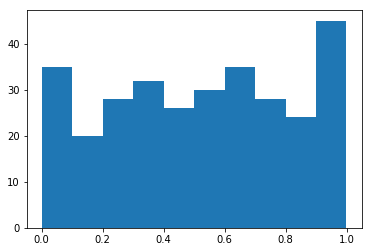

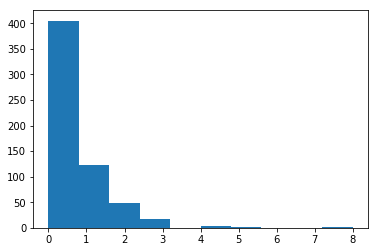

In [5]:
bins = np.load('./data/testing/acc_binary.npy')
freqs = np.load('./data/testing/acc_frequency.npy')
all_preds = np.load('./data/testing/preds_frequency.npy')
all_actuals = np.load('./data/testing/actuals_frequency.npy')
preds = np.reshape(all_preds, -1)
actuals = np.reshape(all_actuals, -1)
wrongs = []
for p, a in zip(preds, actuals):
    if int(np.round(p)) != int(a):
        wrongs.append(p)
print(np.shape(wrongs))
print(bit_to_freq(np.expand_dims(actuals[0:10], 1), 1024))
print(actuals[0:10])
plt.hist(wrongs)
plt.show()
hammings = []
for i in range(len(preds) // 10):
    hammings.append(np.sum([int(round(preds[i*10 + j])) != int(actuals[i*10 + j]) for j in range(10)]))
plt.hist(hammings)
plt.show()
# bit to freq is just inverse of binary representation for freq - use to calc hamming and confidence vs pred